In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, confusion_matrix, adjusted_rand_score, normalized_mutual_info_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

from tensorflow import keras
from tensorflow.keras import layers

In [25]:
train = pd.read_csv('fashion-mnist_train.csv')
test = pd.read_csv('fashion-mnist_test.csv')

In [26]:
train.head()

label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      2       0       0       0       0       0       0       0       0   
1      9       0       0       0       0       0       0       0       0   
2      6       0       0       0       0       0       0       0       5   
3      0       0       0       0       1       2       0       0       0   
4      3       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0        30        43         0   
3       0  ...         3         0         0         0         0         1   
4       0  ...         0         0         0         0         0         0   

   pixel781  pixel782  pixel783  pixel784  
0         0         0         0         0  
1         0         0         0         0  
2         0         0         0         0  
3         0         0         0         0  
4         0         0         0         0  

[5 rows x 785 columns]

In [27]:
train.shape, test.shape

((60000, 785), (10000, 785))

In [28]:
X_train = train.iloc[:, 1:].values / 255 # Normalise
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [29]:
y_train = train.iloc[:, 0].values
y_train

array([2, 9, 6, ..., 8, 8, 7])

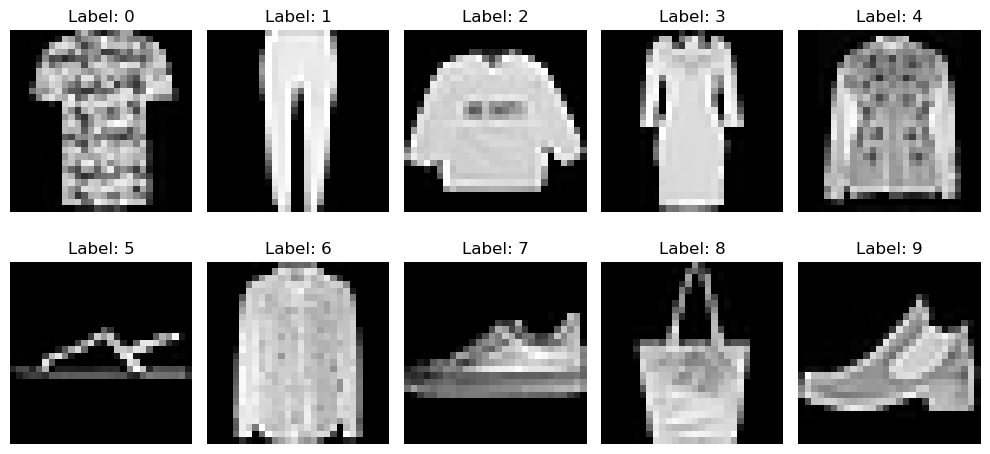

In [30]:
examples = []
labels = []
for label in np.unique(y_train):
    idx = np.where(y_train == label)[0][0]  # first occurrence of the label
    examples.append(X_train[idx])
    labels.append(label)

plt.figure(figsize=(10, 5))
for i, (image, label) in enumerate(zip(examples, labels)):
    plt.subplot(2, 5, i + 1)
    plt.imshow(image.reshape(28, 28), cmap="gray")
    plt.title(f"Label: {label}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [31]:
%%time
kmeans = KMeans(n_clusters=10, n_init=10, random_state=42)

cluster_labels_basic = kmeans.fit_predict(X_train)

CPU times: total: 3min 9s
Wall time: 15.7 s


In [32]:
def calc_results(X_train, y_train, cluster_labels):   
    silhouette = silhouette_score(X_train, cluster_labels)
    ari = adjusted_rand_score(y_train, cluster_labels)
    nmi = normalized_mutual_info_score(y_train, cluster_labels)
    
    print(f"Silhouette Score: {silhouette:.4f}")
    print(f"ARI: {ari:.4f}")
    print(f"NMI: {nmi:.4f}")
calc_results(X_train, y_train, cluster_labels_basic)

Silhouette Score: 0.1433
ARI: 0.3750
NMI: 0.5131


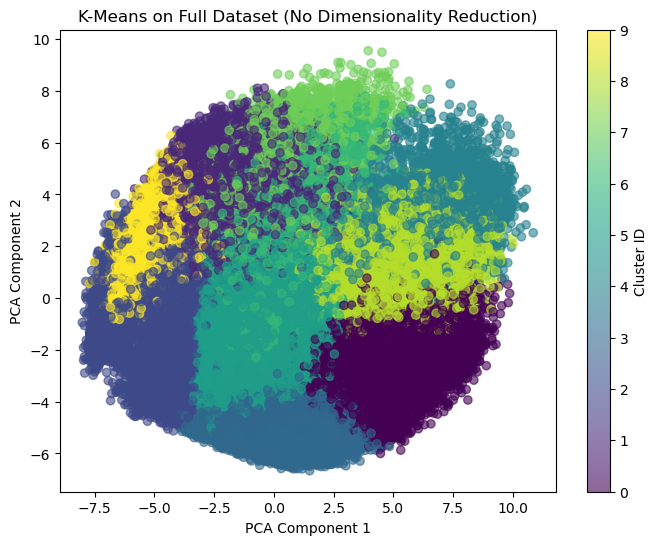

In [33]:
def show_results(X, labels, title):
    pca_2d = PCA(n_components=2, random_state=42)
    X_2d = pca_2d.fit_transform(X)
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, alpha=0.6)
    
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title(title)
    plt.colorbar(scatter, label="Cluster ID")
    plt.show()

show_results(X_train, cluster_labels_basic, 'K-Means on Full Dataset (No Dimensionality Reduction)')

In [34]:
pca_full = PCA(random_state=42)
pca_full.fit(X_train)

PCA(random_state=42)

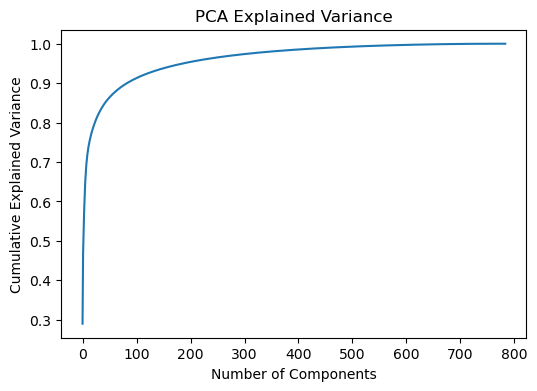

In [35]:
cum_var = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure(figsize=(6, 4))
plt.plot(cum_var)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.show()

In [36]:
np.argwhere(cum_var > 0.95)[0]

array([186])

In [37]:
np.argwhere(cum_var > 0.90)[0]

array([83])

In [38]:
%%time
pca_90 = PCA(n_components=83, random_state=42)
X_90 = pca_90.fit_transform(X_train)

CPU times: total: 5.25 s
Wall time: 867 ms


In [39]:
%%time
kmeans90 = KMeans(n_clusters=10, n_init=10, random_state=42)

cluster_labels_90 = kmeans90.fit_predict(X_90)

CPU times: total: 21.8 s
Wall time: 1.96 s


In [40]:
calc_results(X_90, y_train, cluster_labels_90)

Silhouette Score: 0.1730
ARI: 0.3750
NMI: 0.5131


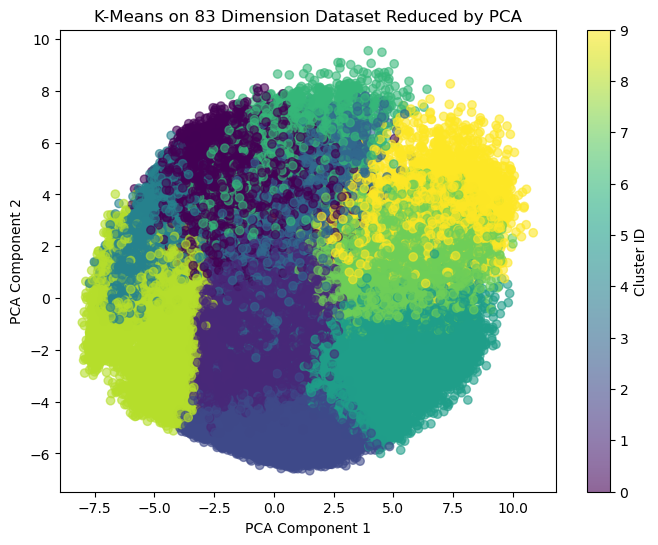

In [41]:
show_results(X_90, cluster_labels_90, 'K-Means on 83 Dimension Dataset Reduced by PCA')

In [42]:
%%time
gmm = GaussianMixture(n_components=10, covariance_type="full", init_params='k-means++', random_state=42)

labels_gmm = gmm.fit_predict(X_90)

CPU times: total: 4min 37s
Wall time: 1min 23s


In [43]:
calc_results(X_90, y_train, labels_gmm)

Silhouette Score: 0.0640
ARI: 0.3181
NMI: 0.5144


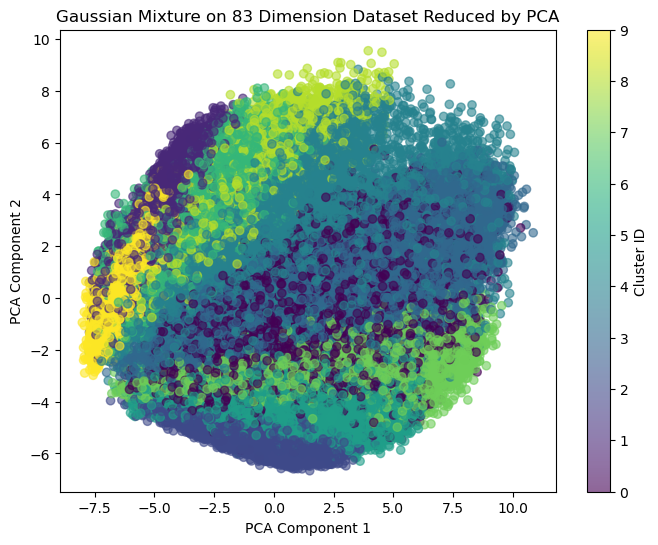

In [44]:
show_results(X_90, labels_gmm, 'Gaussian Mixture on 83 Dimension Dataset Reduced by PCA')

In [45]:
n_samples = 20000

sss = StratifiedShuffleSplit(
    n_splits=1,
    train_size=n_samples,
    random_state=42,
)

idx, _ = next(sss.split(X_train, y_train))
X_subset = X_train[idx]
y_subset = y_train[idx]

X_subset.shape, y_subset.shape

((20000, 784), (20000,))

In [46]:
%%time
pca_subset = PCA(n_components=83, random_state=42)

X_pca_subset = pca_subset.fit_transform(X_subset)

CPU times: total: 2.67 s
Wall time: 824 ms


In [47]:
%%time
agg = AgglomerativeClustering(n_clusters=10, linkage="ward")
 
agg_labels = agg.fit_predict(X_pca_subset)

CPU times: total: 31.2 s
Wall time: 42.7 s


In [48]:
calc_results(X_pca_subset, y_subset, agg_labels)

Silhouette Score: 0.1483
ARI: 0.4311
NMI: 0.5928


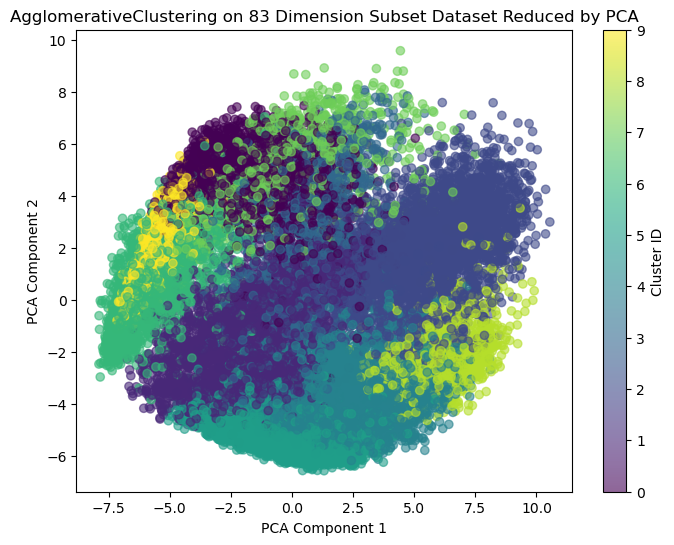

In [49]:
show_results(X_pca_subset, agg_labels, 'AgglomerativeClustering on 83 Dimension Subset Dataset Reduced by PCA')

In [50]:
%%time
pca_95 = PCA(n_components=186, random_state=42)
X_95 = pca_95.fit_transform(X_train)

CPU times: total: 5.83 s
Wall time: 1.9 s


In [51]:
%%time
kmeans95 = KMeans(n_clusters=10, n_init=10, random_state=42)
cluster_labels_95 = kmeans95.fit_predict(X_95)

CPU times: total: 40.2 s
Wall time: 3.41 s


In [52]:
%%time
gmm_95 = GaussianMixture(n_components=10, covariance_type="full", init_params='k-means++', random_state=42)
labels_gmm_95 = gmm_95.fit_predict(X_95)

CPU times: total: 23min 26s
Wall time: 4min 17s


In [87]:
%%time
pca_95 = PCA(n_components=186, random_state=42)
X_pca_subset_95 = pca_95.fit_transform(X_subset)


CPU times: total: 2.42 s
Wall time: 636 ms


In [88]:
%%time
agg_95 = AgglomerativeClustering(n_clusters=10, linkage="ward")
agg_labels_95 = agg_95.fit_predict(X_pca_subset)

CPU times: total: 30.3 s
Wall time: 37.8 s


In [54]:
calc_results(X_95, y_train, cluster_labels_95)

Silhouette Score: 0.1679
ARI: 0.3489
NMI: 0.5128


In [55]:
calc_results(X_95, y_train, labels_gmm_95)

Silhouette Score: 0.0663
ARI: 0.3673
NMI: 0.5515


In [56]:
calc_results(X_pca_subset_95, y_subset, agg_labels_95)

Silhouette Score: 0.1343
ARI: 0.4311
NMI: 0.5928


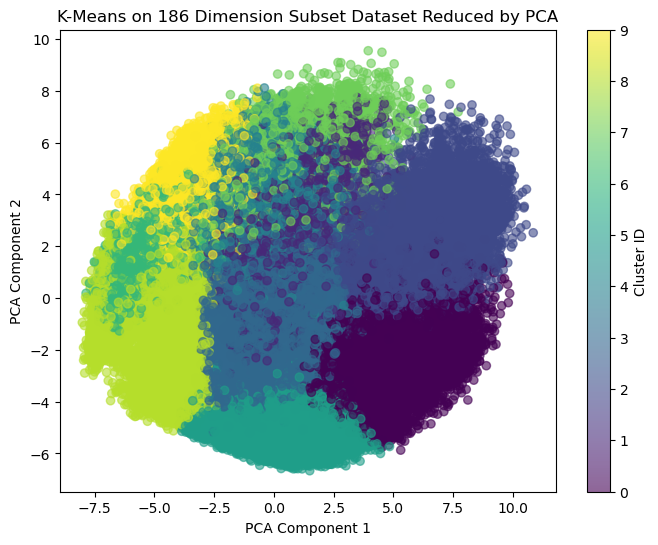

In [57]:
show_results(X_95, cluster_labels_95, 'K-Means on 186 Dimension Subset Dataset Reduced by PCA')

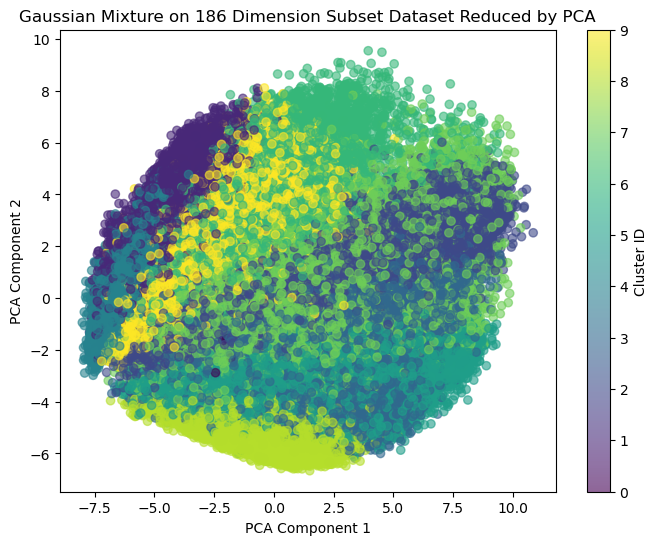

In [58]:
show_results(X_95, labels_gmm_95, 'Gaussian Mixture on 186 Dimension Subset Dataset Reduced by PCA')

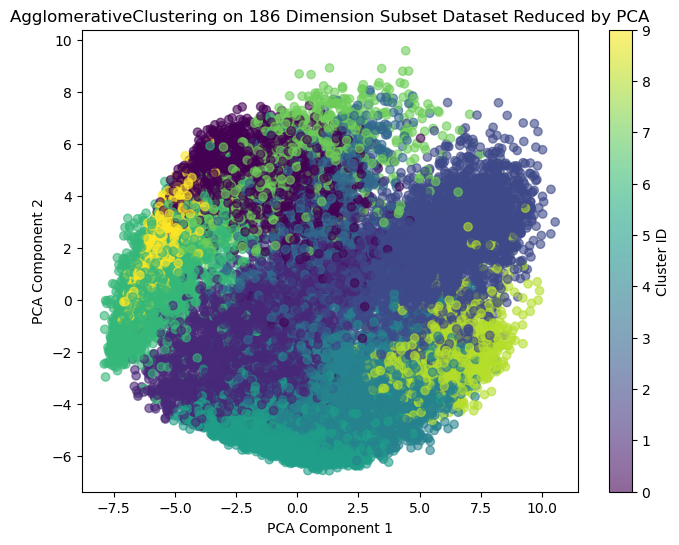

In [59]:
show_results(X_pca_subset_95, agg_labels_95, 'AgglomerativeClustering on 186 Dimension Subset Dataset Reduced by PCA')

## Autoencoder for dimensionality reduction

In [60]:
input_dim = 784

input_layer = keras.Input(shape=(input_dim,))
encode = layers.Dense(512, activation='relu')(input_layer)
encode = layers.Dense(256, activation='relu')(encode)
encode = layers.Dense(128, activation='relu')(encode)
latent = layers.Dense(64, activation='relu', name='latent')(encode)

decode = layers.Dense(128, activation='relu')(latent)
decode = layers.Dense(256, activation='relu')(latent)
decode = layers.Dense(512, activation='relu')(decode)
output = layers.Dense(input_dim, activation='sigmoid')(decode)

autoencoder = keras.Model(input_layer, output)
encoder = keras.Model(input_layer, latent)

autoencoder.compile(
    optimizer="adam",
    loss="mse",
)

autoencoder.fit(
    X_train,
    X_train,
    epochs=20,
    batch_size=256,
    shuffle=True,
    validation_split=0.1,
    verbose=2,
)

Epoch 1/20
211/211 - 16s - 77ms/step - loss: 0.0410 - val_loss: 0.0226
Epoch 2/20
211/211 - 16s - 78ms/step - loss: 0.0200 - val_loss: 0.0184
Epoch 3/20
211/211 - 20s - 96ms/step - loss: 0.0167 - val_loss: 0.0158
Epoch 4/20
211/211 - 21s - 100ms/step - loss: 0.0150 - val_loss: 0.0144
Epoch 5/20
211/211 - 17s - 81ms/step - loss: 0.0138 - val_loss: 0.0146
Epoch 6/20
211/211 - 17s - 79ms/step - loss: 0.0130 - val_loss: 0.0127
Epoch 7/20
211/211 - 17s - 80ms/step - loss: 0.0123 - val_loss: 0.0121
Epoch 8/20
211/211 - 17s - 82ms/step - loss: 0.0118 - val_loss: 0.0116
Epoch 9/20
211/211 - 16s - 78ms/step - loss: 0.0113 - val_loss: 0.0112
Epoch 10/20
211/211 - 20s - 94ms/step - loss: 0.0109 - val_loss: 0.0112
Epoch 11/20
211/211 - 15s - 72ms/step - loss: 0.0106 - val_loss: 0.0105
Epoch 12/20
211/211 - 13s - 59ms/step - loss: 0.0103 - val_loss: 0.0105
Epoch 13/20
211/211 - 14s - 69ms/step - loss: 0.0100 - val_loss: 0.0100
Epoch 14/20
211/211 - 20s - 95ms/step - loss: 0.0098 - val_loss: 0.0102


In [61]:
%%time
X_latent = encoder.predict(X_train, batch_size=256)

kmeans_ae = KMeans(
    n_clusters=10,
    n_init="auto",
    random_state=42,
)

kmeans_ae_labels = kmeans_ae.fit_predict(X_latent)

print("Latent shape:", X_latent.shape)
print("Cluster labels:", np.bincount(kmeans_ae_labels))

235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
Latent shape: (60000, 64)
Cluster labels: [12661  2356  6459  8948  4539  2839  8451  1586  4657  7504]
CPU times: total: 4.17 s
Wall time: 6.27 s


In [62]:
calc_results(X_latent, y_train, kmeans_ae_labels)

Silhouette Score: 0.1564
ARI: 0.2840
NMI: 0.4847


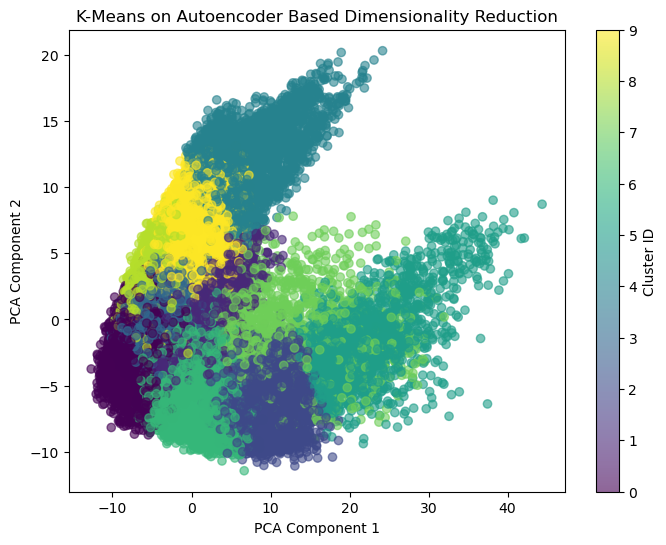

In [63]:
show_results(X_latent, kmeans_ae_labels, 'K-Means on Autoencoder Based Dimensionality Reduction')

In [64]:
%%time
gmm_ae = GaussianMixture(n_components=10, covariance_type="full", random_state=42)
gmm_ae_labels = gmm_ae.fit_predict(X_latent)

CPU times: total: 2min 35s
Wall time: 26.4 s


In [65]:
calc_results(X_latent, y_train, gmm_ae_labels)

Silhouette Score: 0.0798
ARI: 0.4293
NMI: 0.5864


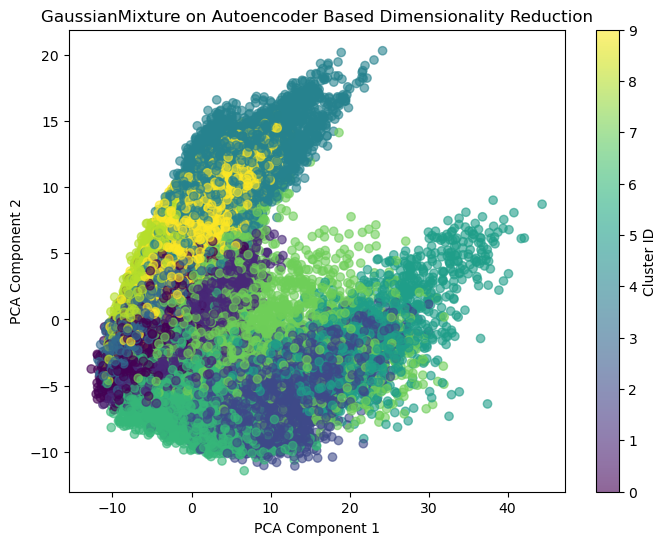

In [66]:
show_results(X_latent, gmm_ae_labels, 'GaussianMixture on Autoencoder Based Dimensionality Reduction')

In [67]:
autoencoder_subset = keras.Model(input_layer, output)
encoder_subset = keras.Model(input_layer, latent)

autoencoder_subset.compile(
    optimizer="adam",
    loss="mse",
)

autoencoder_subset.fit(
    X_subset,
    X_subset,
    epochs=20,
    batch_size=256,
    shuffle=True,
    validation_split=0.1,
    verbose=2,
)
X_subset_latent = encoder_subset.predict(X_subset, batch_size=256)

Epoch 1/20
71/71 - 10s - 135ms/step - loss: 0.0139 - val_loss: 0.0090
Epoch 2/20
71/71 - 4s - 57ms/step - loss: 0.0086 - val_loss: 0.0088
Epoch 3/20
71/71 - 5s - 72ms/step - loss: 0.0084 - val_loss: 0.0087
Epoch 4/20
71/71 - 4s - 59ms/step - loss: 0.0084 - val_loss: 0.0087
Epoch 5/20
71/71 - 4s - 54ms/step - loss: 0.0084 - val_loss: 0.0088
Epoch 6/20
71/71 - 4s - 60ms/step - loss: 0.0084 - val_loss: 0.0088
Epoch 7/20
71/71 - 5s - 70ms/step - loss: 0.0083 - val_loss: 0.0087
Epoch 8/20
71/71 - 5s - 64ms/step - loss: 0.0082 - val_loss: 0.0088
Epoch 9/20
71/71 - 5s - 76ms/step - loss: 0.0082 - val_loss: 0.0087
Epoch 10/20
71/71 - 4s - 60ms/step - loss: 0.0081 - val_loss: 0.0087
Epoch 11/20
71/71 - 5s - 75ms/step - loss: 0.0081 - val_loss: 0.0086
Epoch 12/20
71/71 - 5s - 67ms/step - loss: 0.0081 - val_loss: 0.0087
Epoch 13/20
71/71 - 5s - 64ms/step - loss: 0.0080 - val_loss: 0.0085
Epoch 14/20
71/71 - 7s - 95ms/step - loss: 0.0079 - val_loss: 0.0095
Epoch 15/20
71/71 - 4s - 56ms/step - loss

In [68]:
%%time
agg_ae = AgglomerativeClustering(n_clusters=10, linkage="ward")
agg_ae_labels = agg_ae.fit_predict(X_subset_latent)

CPU times: total: 26.9 s
Wall time: 44 s


In [69]:
calc_results(X_subset_latent, y_subset, agg_ae_labels)

Silhouette Score: 0.1131
ARI: 0.3185
NMI: 0.5271


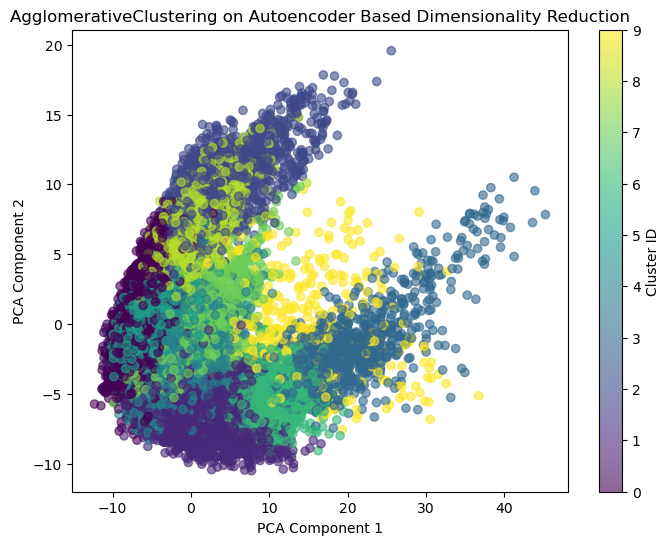

In [70]:
show_results(X_subset_latent, agg_ae_labels, 'AgglomerativeClustering on Autoencoder Based Dimensionality Reduction')

## UMAP Dimensionality Reduction

%%time
umap_model = umap.UMAP(
    n_components=32,
    n_neighbors=15,
    min_dist=0.1,
    metric="euclidean",
    random_state=42,
)

X_umap = umap_model.fit_transform(X_train)

In [72]:
%%time
kmeans_umap = KMeans(n_clusters=10, n_init=10, random_state=42)
kmeans_umap_labels = kmeans_umap.fit_predict(X_umap)

CPU times: total: 14 s
Wall time: 3.43 s


In [73]:
calc_results(X_umap, y_train, kmeans_umap_labels)

Silhouette Score: 0.5099
ARI: 0.4873
NMI: 0.6489


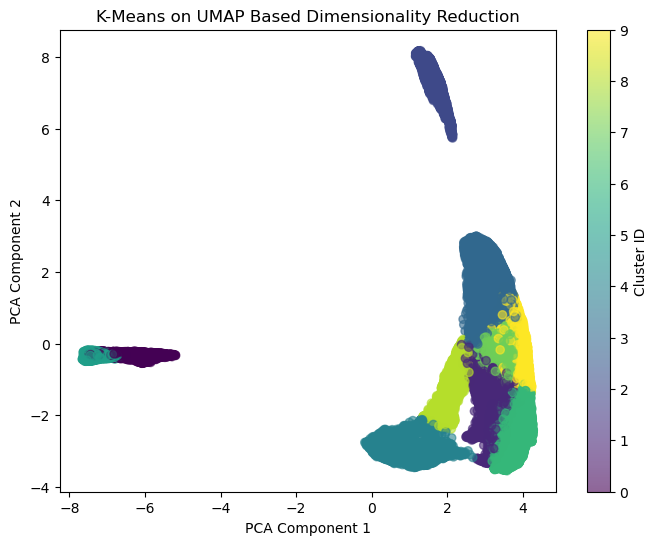

In [74]:
show_results(X_umap, kmeans_umap_labels, 'K-Means on UMAP Based Dimensionality Reduction')

In [75]:
%%time
gmm_umap = GaussianMixture(n_components=10, covariance_type="full", init_params='k-means++', random_state=42)
gmm_umap_labels = gmm_ae.fit_predict(X_umap)

CPU times: total: 9.55 s
Wall time: 3.82 s


In [76]:
calc_results(X_umap, y_train, gmm_umap_labels)

Silhouette Score: 0.4701
ARI: 0.4868
NMI: 0.6463


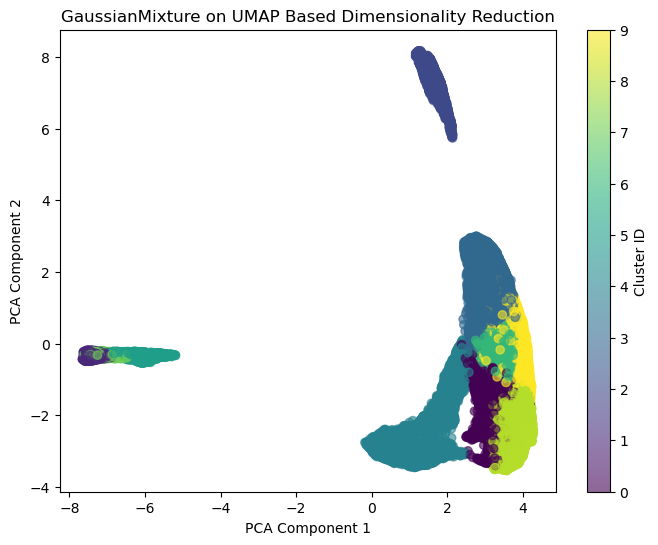

In [77]:
show_results(X_umap, gmm_umap_labels, 'GaussianMixture on UMAP Based Dimensionality Reduction')

In [78]:
%%time
umap_subset = umap.UMAP(
    n_components=32,
    n_neighbors=15,
    min_dist=0.1,
    metric="euclidean",
    random_state=42,
)

X_umap_subset = umap_subset.fit_transform(X_subset)

C:\Users\pokem\anaconda3\envs\myenv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


CPU times: total: 39.4 s
Wall time: 52.5 s


In [79]:
%%time
agg_umap = AgglomerativeClustering(n_clusters=10, linkage="ward")
agg_umap_labels = agg_umap.fit_predict(X_subset)

CPU times: total: 2min 46s
Wall time: 4min 2s


In [80]:
calc_results(X_umap_subset, y_subset, agg_umap_labels)

Silhouette Score: 0.3086
ARI: 0.4048
NMI: 0.5508


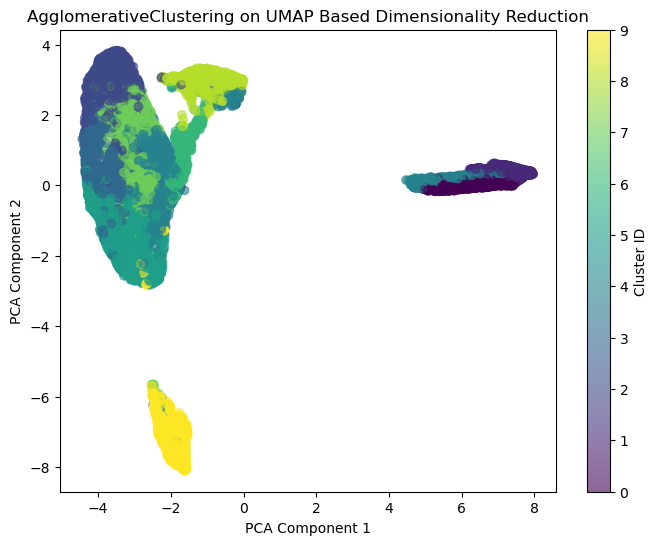

In [81]:
show_results(X_umap_subset, agg_umap_labels, 'AgglomerativeClustering on UMAP Based Dimensionality Reduction')

In [82]:
def show_cluster_samples_grid(
    X,
    y_true,
    y_pred,
    n_clusters=10,
    n_samples=10,
    title=None,
    save_name=None,
    dpi=100,
):
    fig, axes = plt.subplots(
        n_clusters,
        n_samples,
        figsize=(n_samples, n_clusters),
    )

    if title:
        fig.suptitle(title, fontsize=12, y=0.99)

    for cid in range(n_clusters):
        idx = np.where(y_pred == cid)[0][:n_samples]

        for i in range(n_samples):
            ax = axes[cid, i]
            if i < len(idx):
                j = idx[i]
                ax.imshow(X[j].reshape(28, 28), cmap="gray")
                ax.set_title(str(y_true[j]), fontsize=6)
            ax.axis("off")

        fig.text(
            0.01,
            0.98 - (cid + 0.45) / n_clusters,
            f"Cluster {cid}",
            va="center",
            fontsize=8,
        )

    plt.tight_layout(rect=[0.05, 0, 1, 1])
    if save_name:
        fig.savefig(
            save_name,
            dpi=dpi,
            bbox_inches="tight",
            pad_inches=0.05,
            format="png",
        )
        plt.close(fig)
    else:
        plt.show()


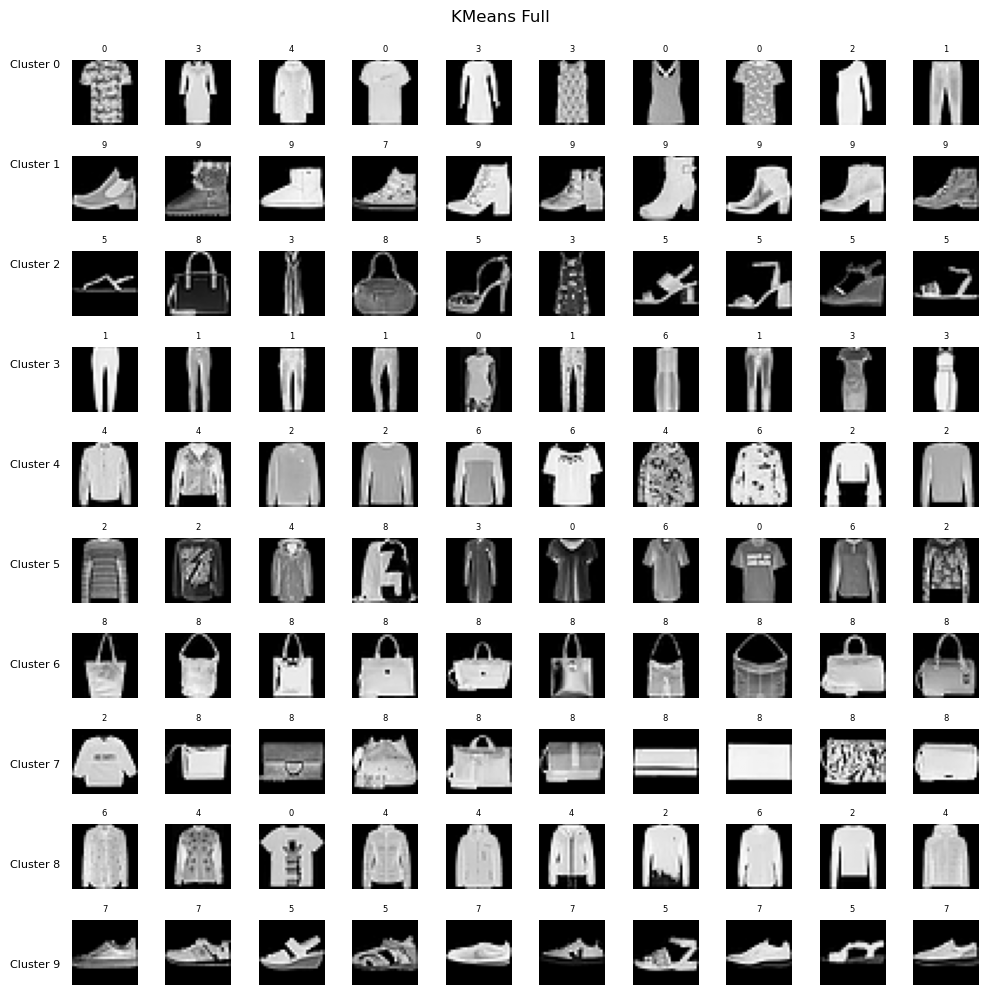

In [83]:
show_cluster_samples_grid(X_train, y_train, cluster_labels_basic, title='KMeans Full') #save_name='kmeans_full.png')

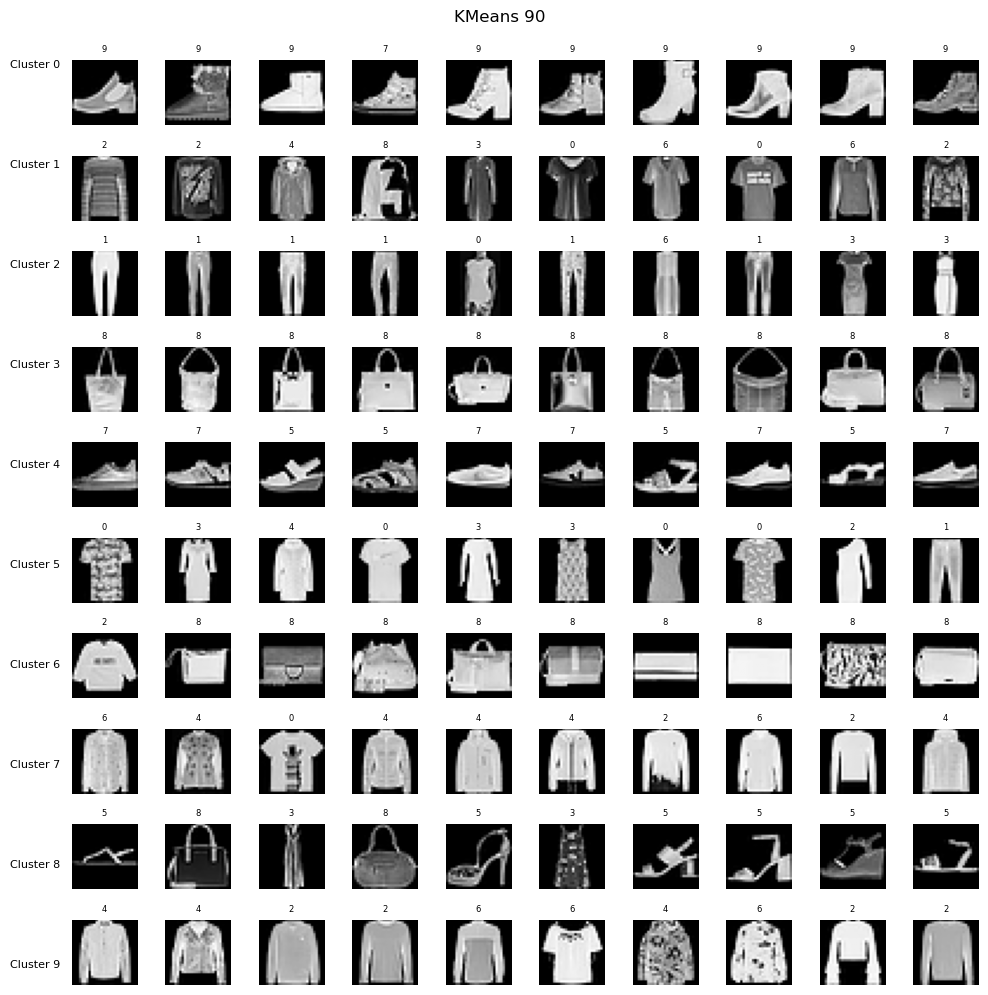

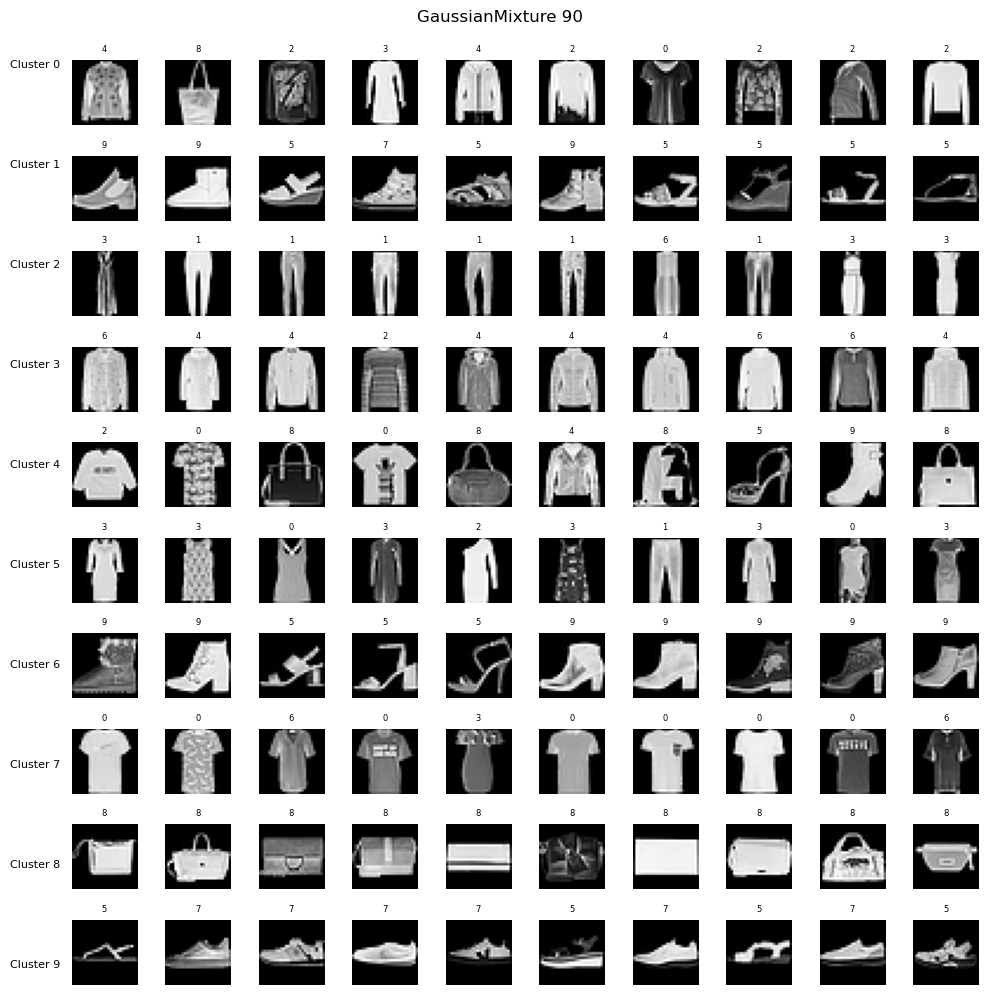

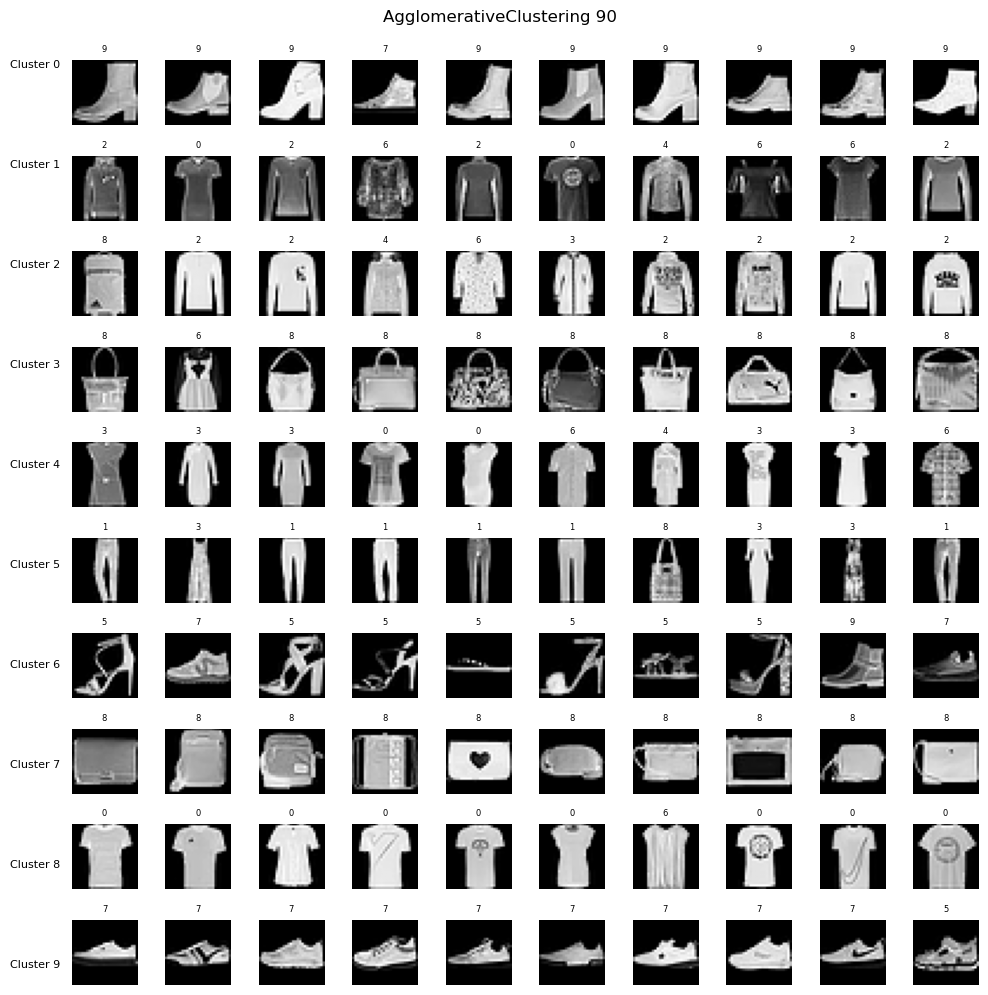

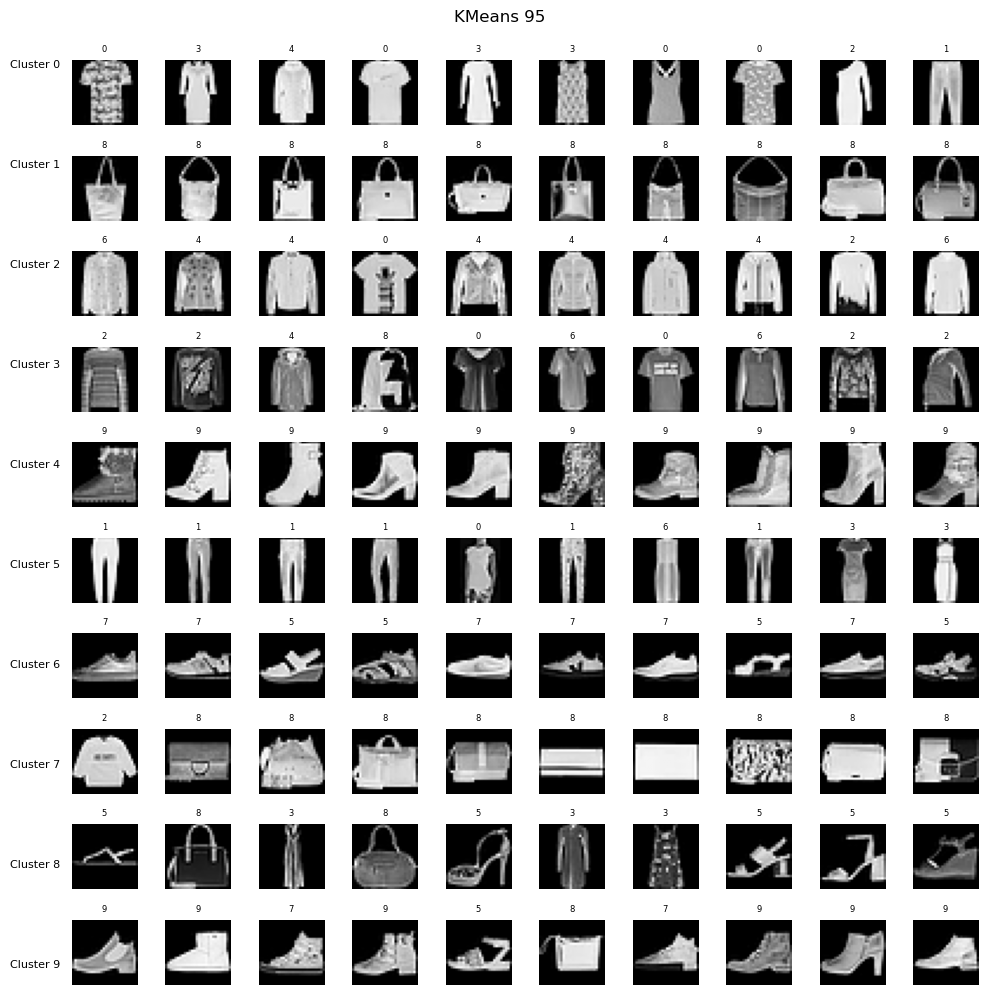

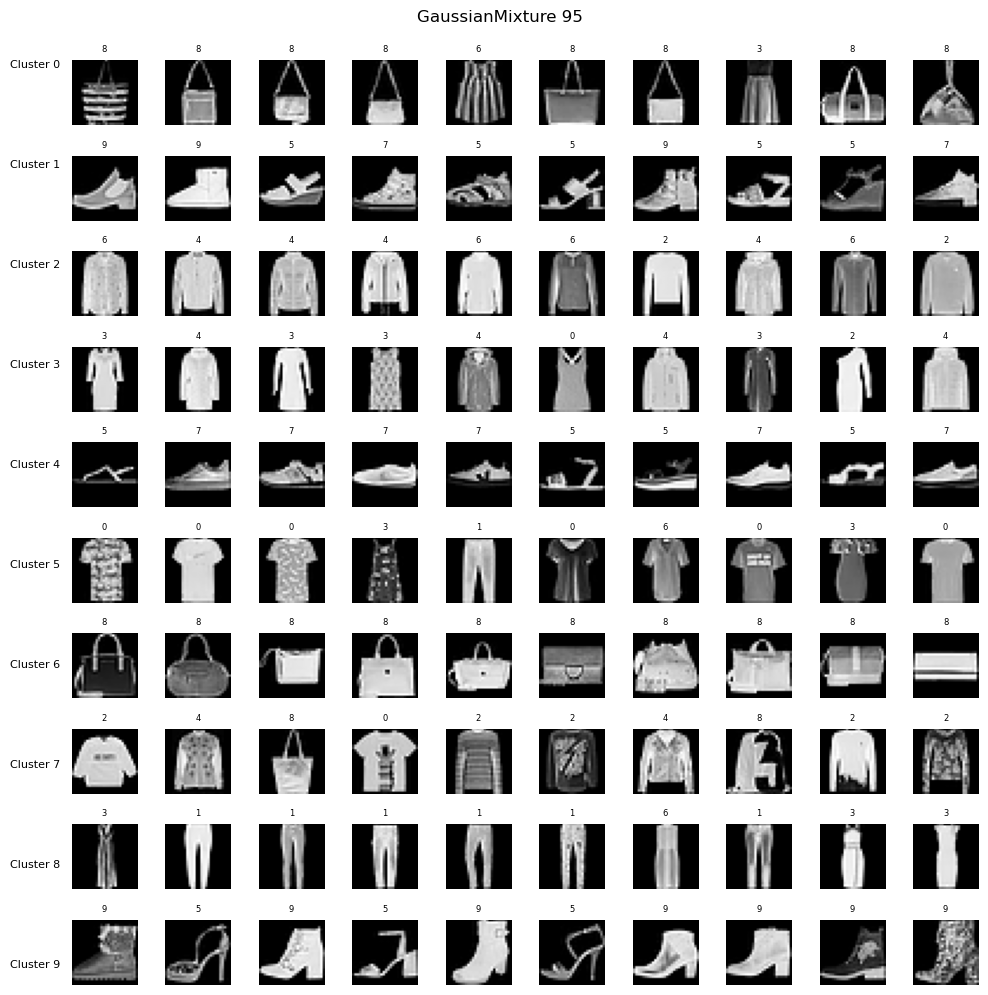

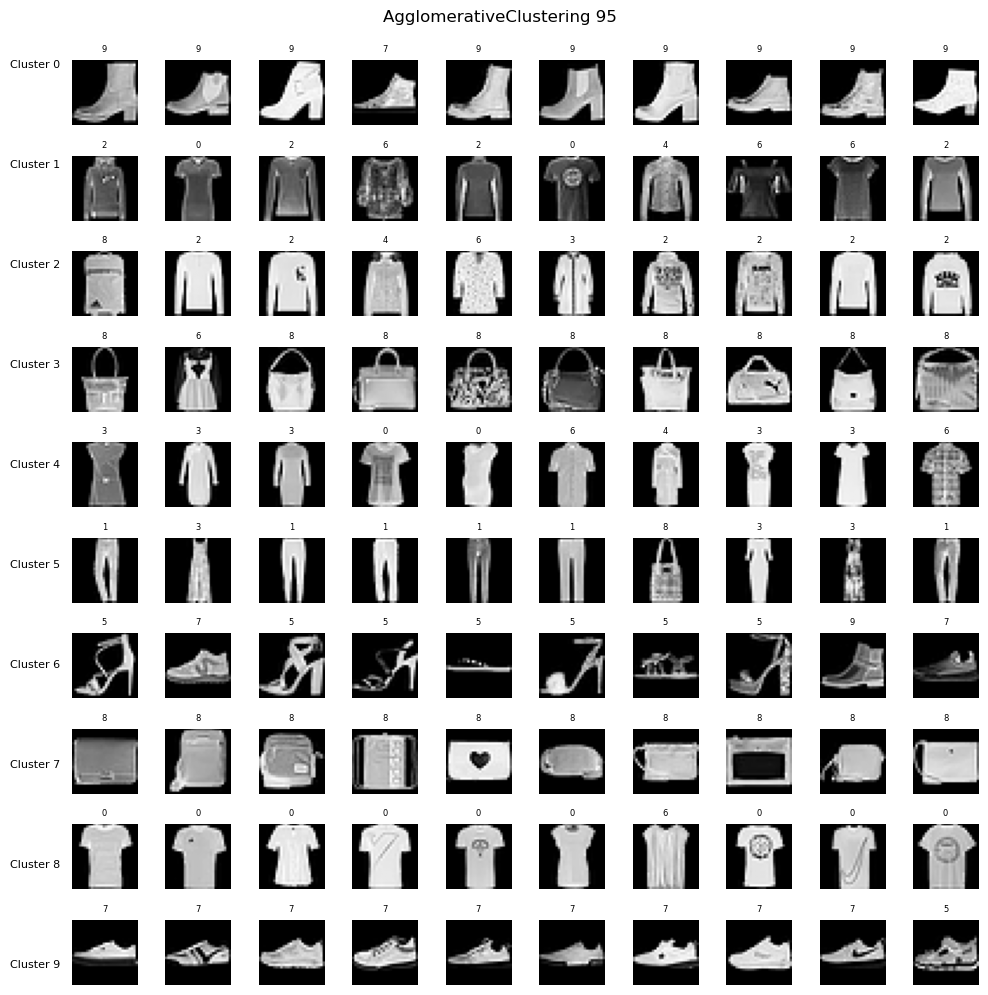

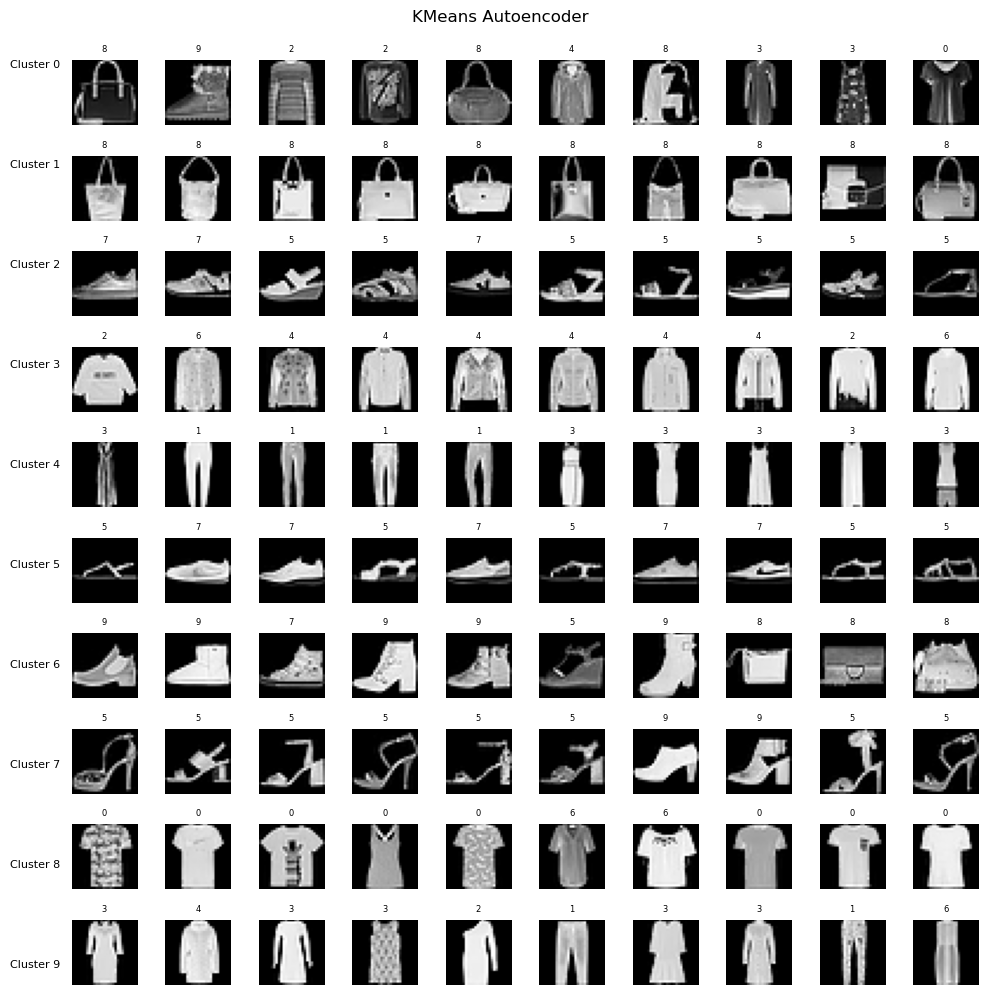

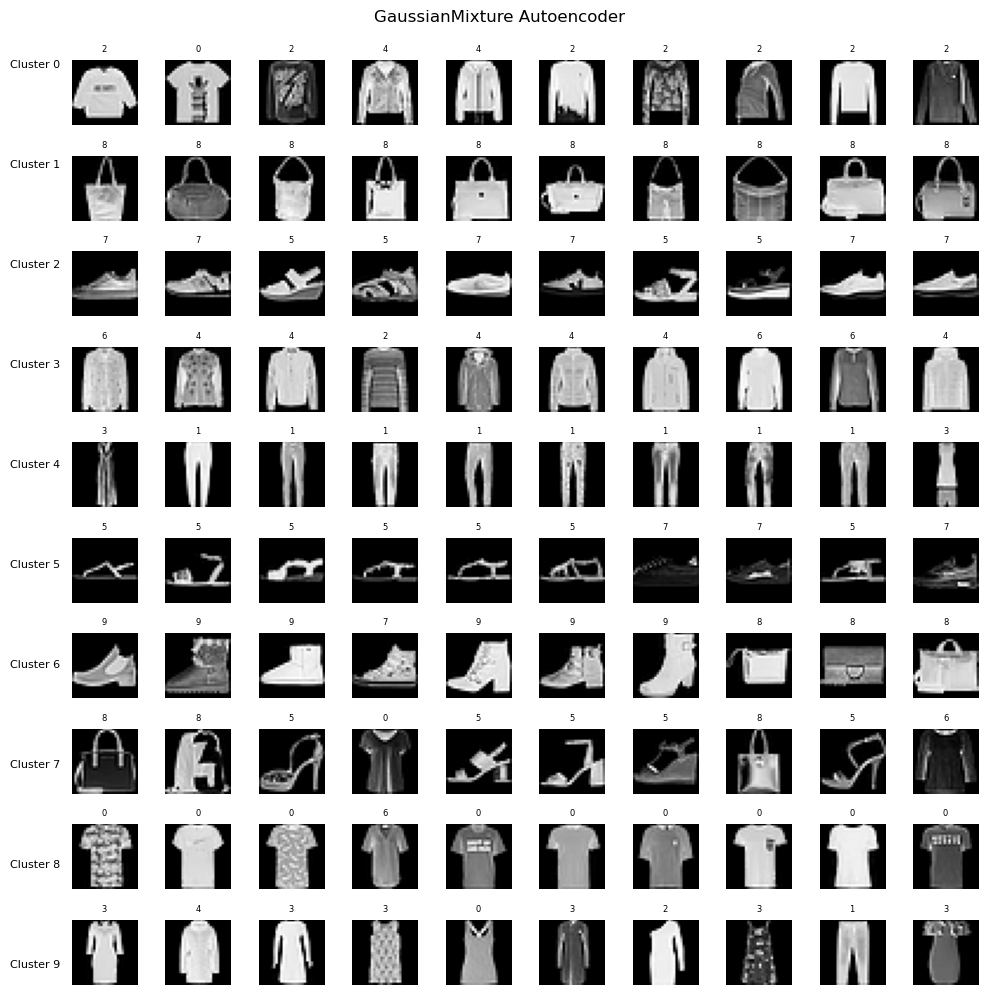

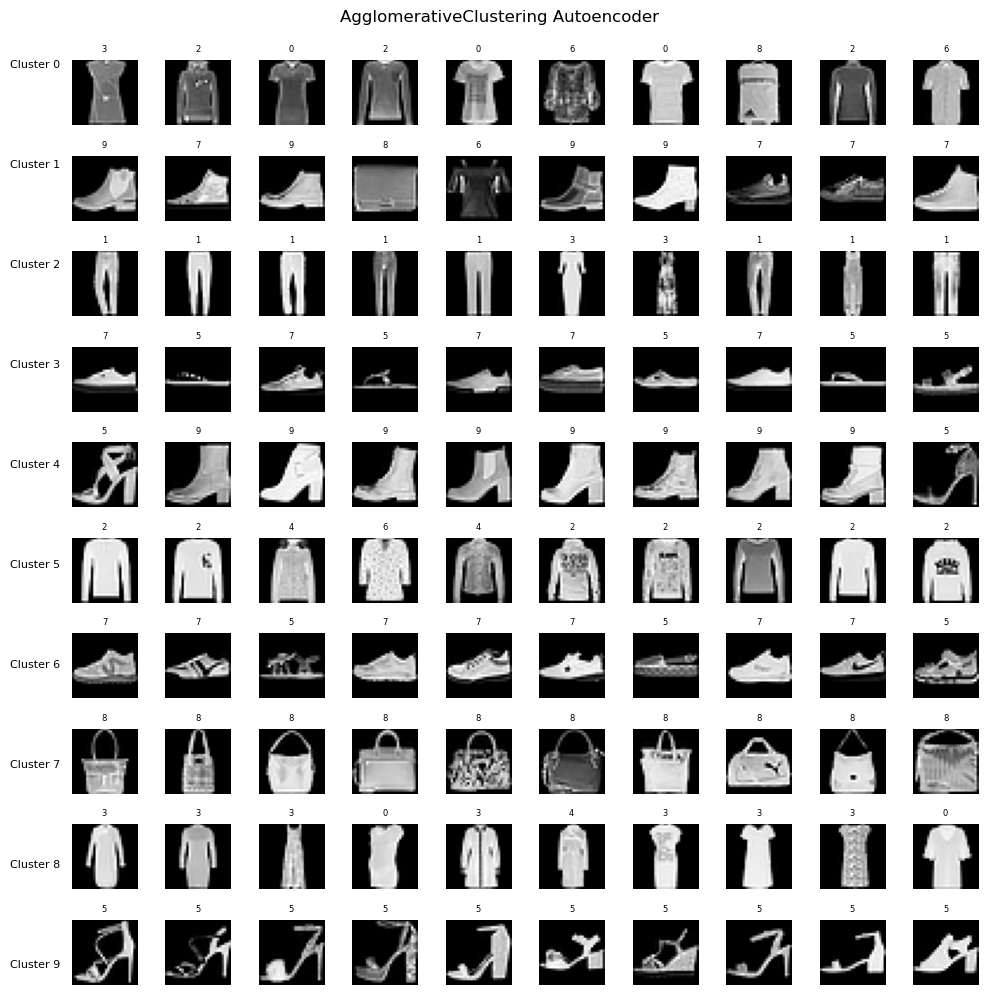

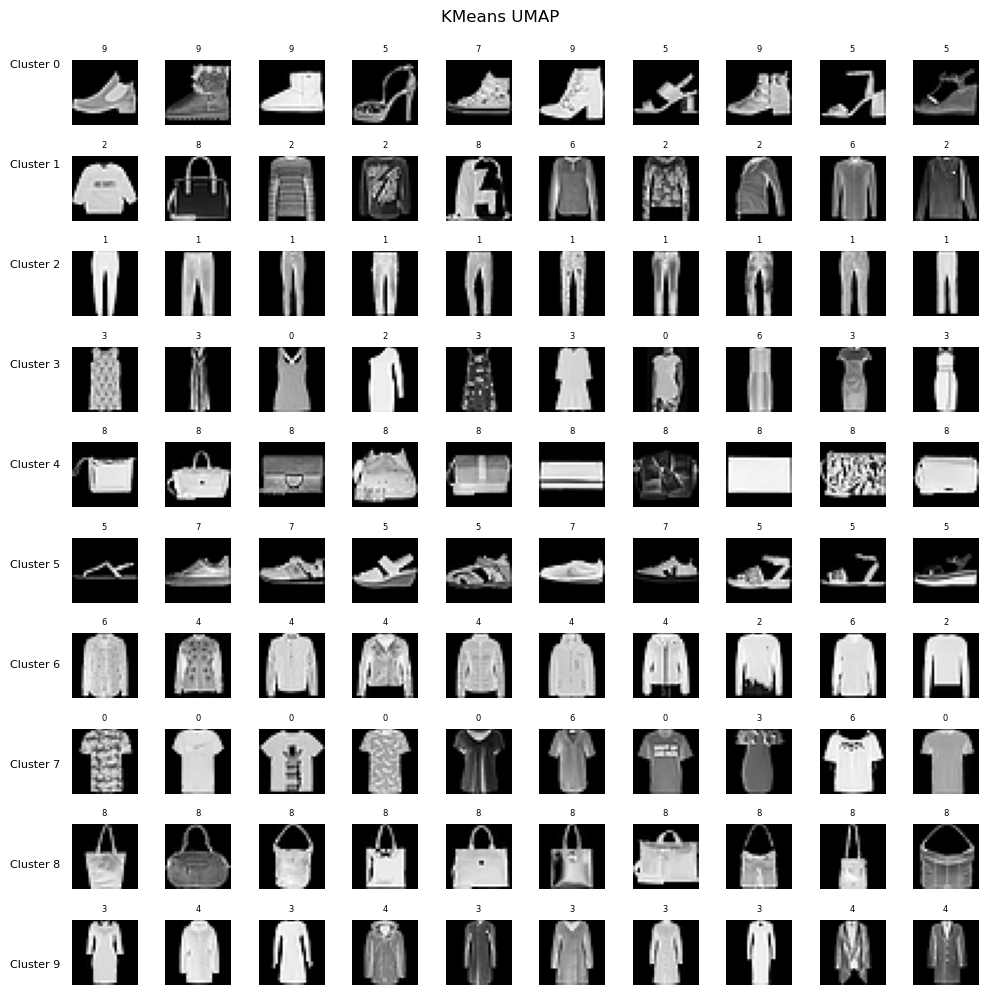

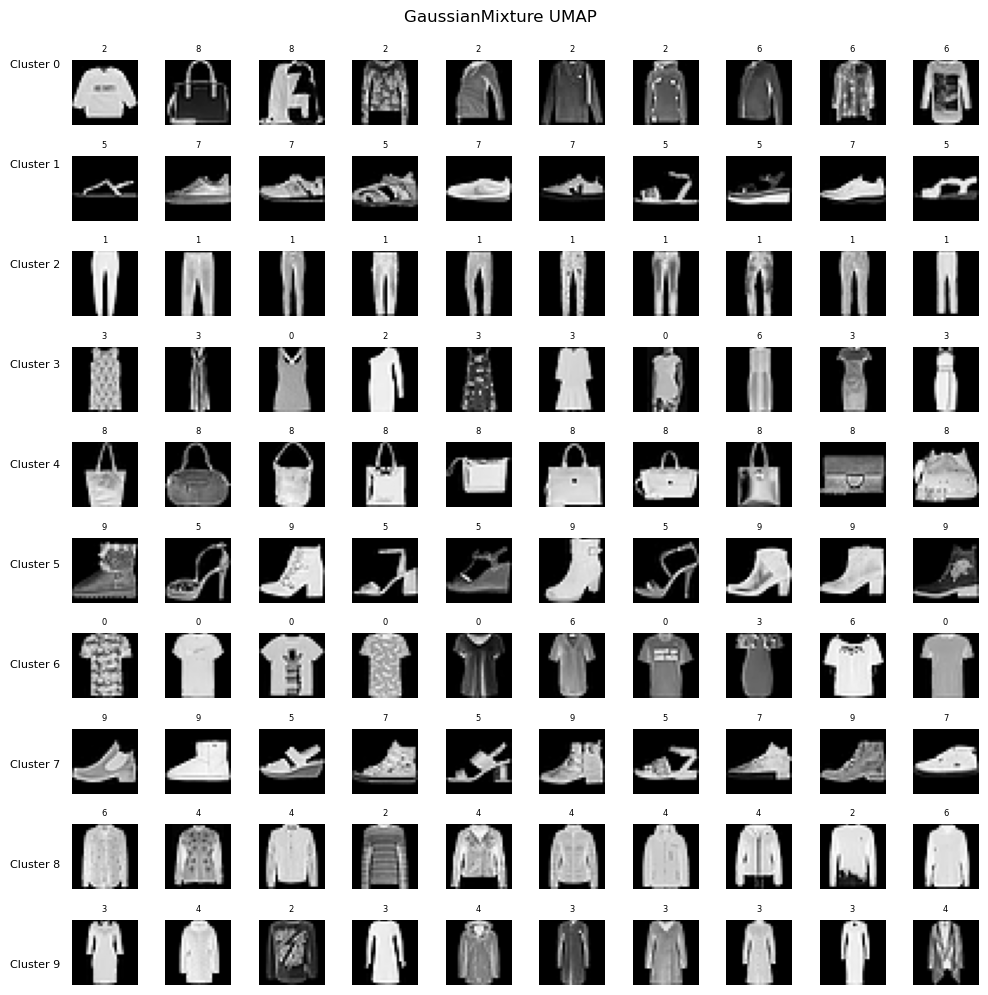

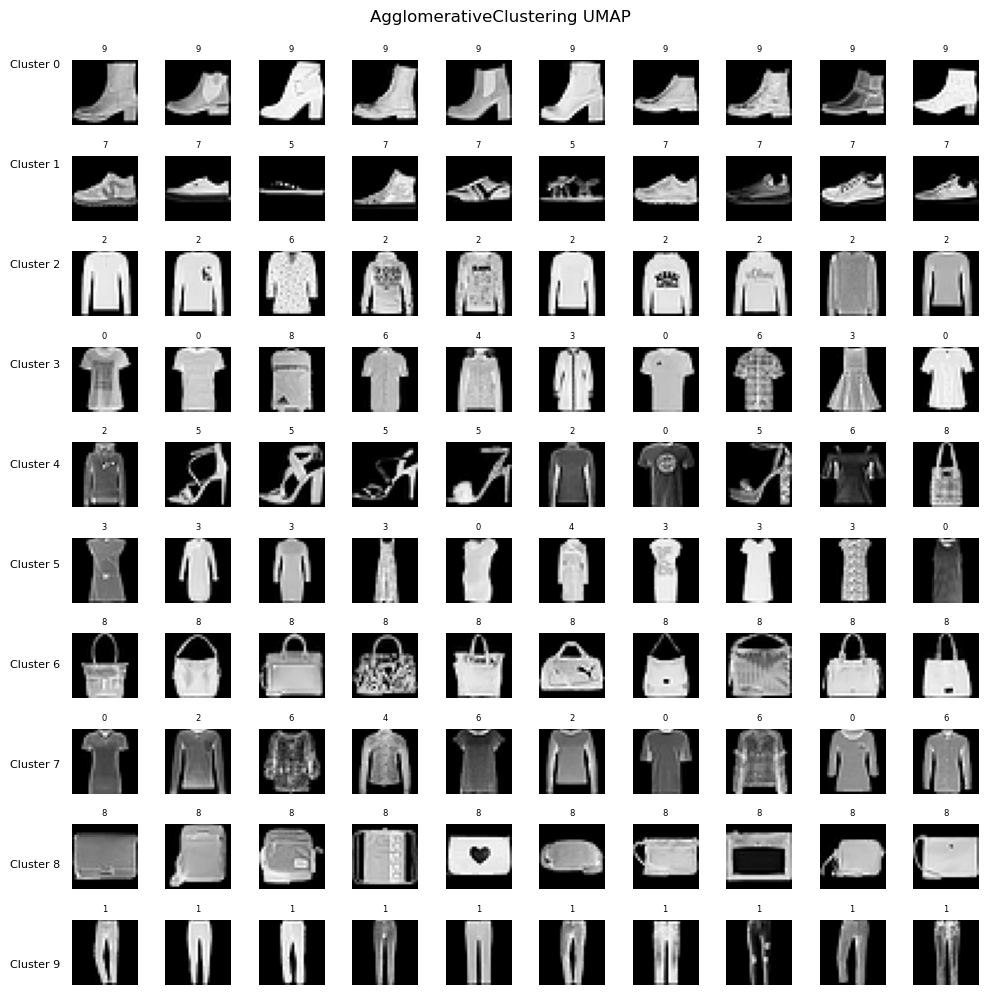

In [84]:
label_list = [
    ("KMeans 90", cluster_labels_90),
    ("GaussianMixture 90", labels_gmm),
    ("AgglomerativeClustering 90", agg_labels),
    ("KMeans 95", cluster_labels_95),
    ("GaussianMixture 95", labels_gmm_95),
    ("AgglomerativeClustering 95", agg_labels_95),
    ("KMeans Autoencoder", kmeans_ae_labels),
    ("GaussianMixture Autoencoder", gmm_ae_labels),
    ("AgglomerativeClustering Autoencoder", agg_ae_labels),
    ("KMeans UMAP", kmeans_umap_labels),
    ("GaussianMixture UMAP", gmm_umap_labels),
    ("AgglomerativeClustering UMAP", agg_umap_labels),
]
    
for name, labels in label_list:
    if "Agg" in name:
        X, y = X_subset, y_subset
    else:
        X, y = X_train, y_train

    show_cluster_samples_grid(
        X,
        y,
        labels,
        title=name,
        #save_name=f"{name}.png"
    )